# BARRA <> DEA example notebook

This is a prototype notebook demonstrating the use of BARRA reanalysis data, specifically
the BARRA-R^1 'accum_prcp'^2 variable.

To be able to execute this notebook, you will need to have completed a "licence schedule" outlining
the usage rights to BARRA data, as well as requesting access to the NCI project 'ma05'.

1 - BARRA domain representing Australian continent <br />
2 - hourly accumulated precipitation including rainfall and snowfall

For more information on BARRA and the data used in this notebook, please see:

In [1]:
import datacube
import rasterio
import time
import os
from datacube.helpers import write_geotiff
from matplotlib import pyplot
from datacube.storage import masking


## Optional helper functions

In [2]:
def write_barra_data(filename, target_dataset, source_affine, nodata=-1.073741824):
    profile_override = {'nodata': nodata, 'transform': source_affine}
    write_geotiff(filename, target_dataset.squeeze(), profile_override=profile_override)

In [3]:
def flip_barra_data(source_dataset, target_variable='accum_prcp'):
    temp_dataarray = source_dataset[target_variable].reindex(latitude=source_dataset[target_variable].latitude[::-1])
    target_dataset = temp_dataarray.to_dataset()
    target_dataset.attrs = temp_dataarray.attrs
    return target_dataset

## Before loading BARRA data...

In [5]:
# Because GDAL struggles with the BARRA NetCDF format we have two choices:
# we leave everything unmolested but exruiciatingly slow
# or
# we use the following directive. This helps GDAL read the file
# metadata correctly but it has the unfortunate side effect of flipping our data.
# Depending on what other data sourced you are reading from , you may need to 
# explicitly set this flag back to YES to avoid any unforeseen consequences
os.environ['GDAL_NETCDF_BOTTOMUP'] = 'NO'

# you will need a datacube.conf file with the following:
# [barra-dev]
# db_hostname: agdcdev-db.nci.org.au
# db_port: 6432
# db_database: dg6911
config = {
    'db_hostname': 'agdcdev-db.nci.org.au',
    'db_port': 6432,
    'db_database': 'dg6911'
}
dc = datacube.Datacube(config=config)

## Querying BARRA data

In [6]:
# this paricular BARRA variable has hourly time steps

barra_datasets = dc.find_datasets(product='accum_prcp',time='1990')
print(len(barra_datasets))

barra_datasets = dc.find_datasets(product='accum_prcp',time='1990-01')
print(len(barra_datasets))

barra_datasets = dc.find_datasets(product='accum_prcp',time='1990-01-01')
print(len(barra_datasets))

barra_datasets = dc.find_datasets(product='accum_prcp',time='1990-01-01T00:00:00.0000Z')
print(len(barra_datasets))

8760
744
24
1


In [7]:
barra_datasets

[Dataset <id=36210852-cbc3-5ae4-98ca-37e357a51a35 type=accum_prcp location=file:/g/data/ma05/BARRA_R/v1/forecast/spec/accum_prcp/1990/01/accum_prcp-fc-spec-PT1H-BARRA_R-v1-19900101T0000Z.sub.nc#part=0>]

In [15]:
os.environ['GDAL_NETCDF_BOTTOMUP'] = 'YES'

query = {}
query['longitude'] = (146.7237, 150.6651)
query['latitude'] = (-34.6732, -36.2835)
query['crs'] = 'EPSG:4326'
#query['resolution'] = (-12500, 12500)
#query['output_crs'] = 'EPSG:3577'
query['resampling'] = 'max'
accum_prcp = dc.load(product='accum_prcp',
                     time='1990-01-01T00:00:00.0000Z',
                     #**query
                    )
print(accum_prcp)

<xarray.Dataset>
Dimensions:     (latitude: 768, longitude: 1200, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 1990-01-01T00:29:59.999999
  * latitude    (latitude) float64 -64.95 -64.84 -64.73 ... 19.2 19.31 19.42
  * longitude   (longitude) float64 65.06 65.17 65.28 ... 196.7 196.8 196.9
Data variables:
    accum_prcp  (time, latitude, longitude) float64 0.003953 0.004181 ... 0.0
Attributes:
    crs:      GEOGCS["unknown",DATUM["unknown",SPHEROID["Sphere",6371229,0]],...


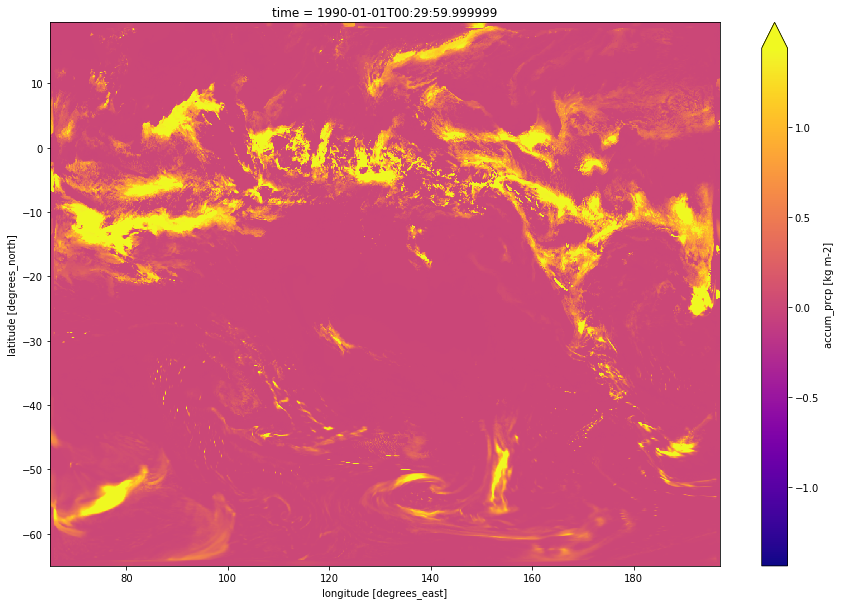

In [16]:
accum_prcp['accum_prcp'].squeeze().plot.imshow(cmap='plasma', robust=True, size=10)

## Slow Load vs Fast Load plus Flip

CPU times: user 18.9 s, sys: 797 ms, total: 19.7 s
Wall time: 25.1 s


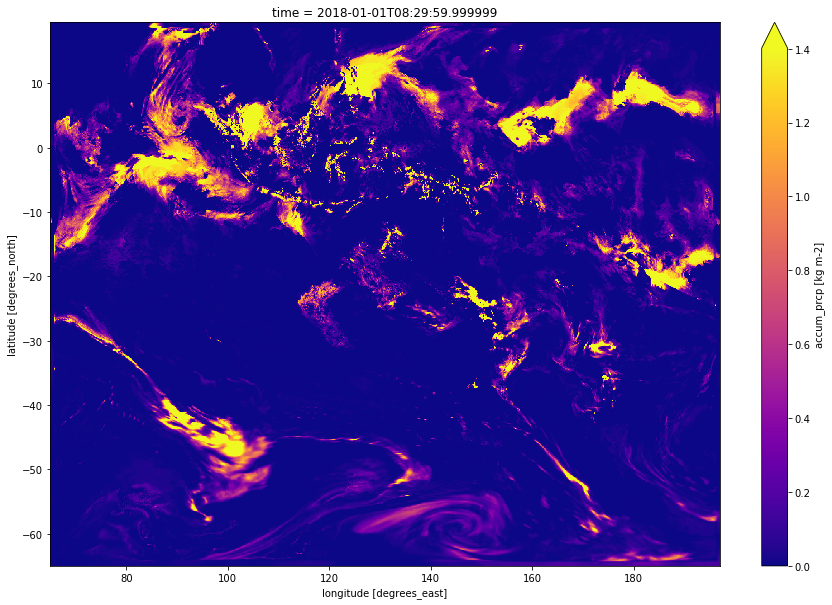

In [23]:
# Slow load
os.environ['GDAL_NETCDF_BOTTOMUP'] = 'YES' #GDAL default is YES

%time slow_accum_prcp = dc.load(product='accum_prcp', time='2018-01-01T08:00:00.0000Z')
slow_accum_prcp['accum_prcp'].squeeze().plot.imshow(cmap='plasma', size=10, robust=True)


CPU times: user 164 ms, sys: 135 ms, total: 299 ms
Wall time: 4.91 s


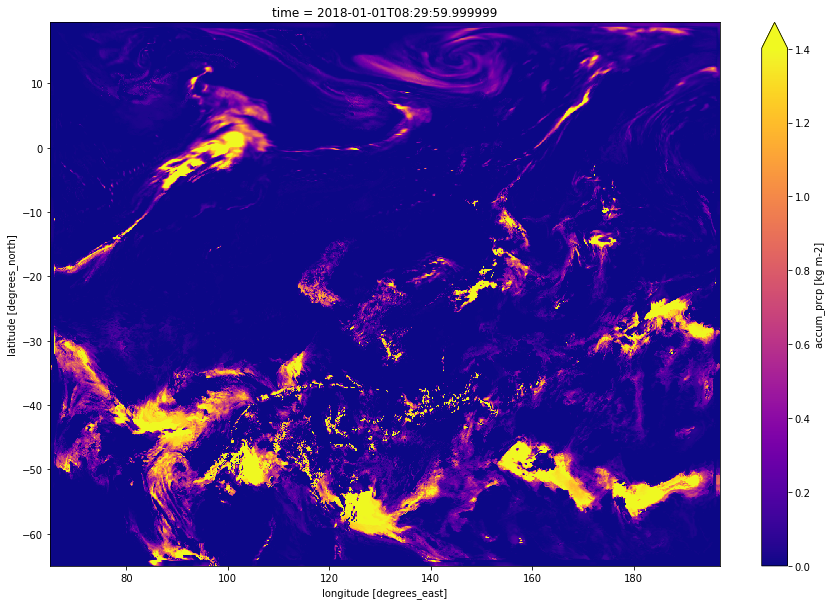

In [24]:
# Fast load, no flip
os.environ['GDAL_NETCDF_BOTTOMUP'] = 'NO' 

%time fast_accum_prcp = dc.load(product='accum_prcp', time='2018-01-01T08:00:00.0000Z')
fast_accum_prcp['accum_prcp'].squeeze().plot.imshow(cmap='plasma', size=10, robust=True)


In [25]:
print(fast_accum_prcp)

<xarray.Dataset>
Dimensions:     (latitude: 768, longitude: 1200, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2018-01-01T08:29:59.999999
  * latitude    (latitude) float64 -64.95 -64.84 -64.73 ... 19.2 19.31 19.42
  * longitude   (longitude) float64 65.06 65.17 65.28 ... 196.7 196.8 196.9
Data variables:
    accum_prcp  (time, latitude, longitude) float64 0.0 0.0 ... 0.1601 0.1581
Attributes:
    crs:      GEOGCS["unknown",DATUM["unknown",SPHEROID["Sphere",6371229,0]],...


In [28]:
fast_accum_prcp.accum_prcp.latitude == slow_accum_prcp.accum_prcp.latitude

<xarray.DataArray 'latitude' (latitude: 768)>
array([ True,  True,  True, ...,  True,  True,  True])
Coordinates:
  * latitude  (latitude) float64 -64.95 -64.84 -64.73 ... 19.2 19.31 19.42

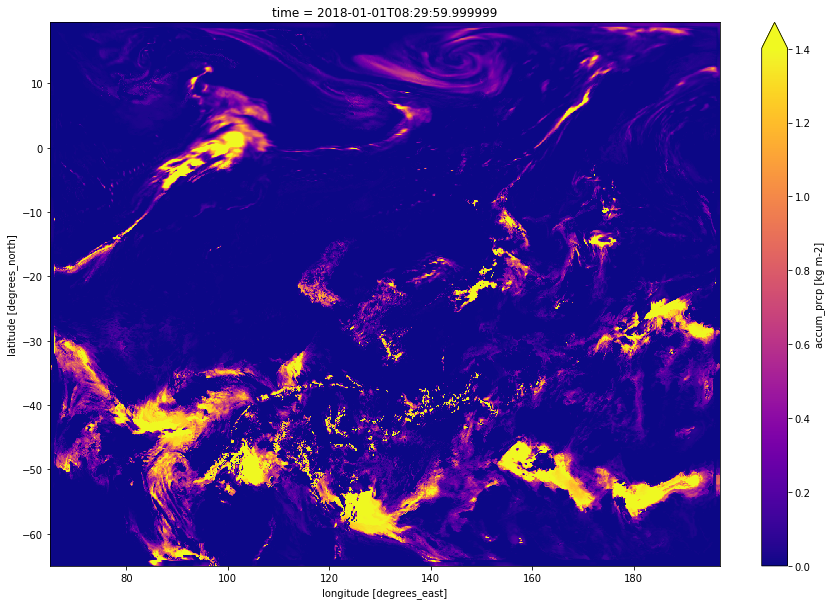

In [20]:
# keep affine
affine = accum_prcp['accum_prcp'].affine
flipped_accum_prcp = flip_barra_data(accum_prcp)
flipped_accum_prcp['accum_prcp'].squeeze().plot.imshow(cmap='plasma', size=10, robust=True)

## Writing BARRA as GeoTIFF

In [ ]:
# following from above
write_barra_data('20180101T0800Z_accum_prcp.tiff', flipped_accum_prcp, affine)

## Producing summaries

In [ ]:
start = time.time()
# lets produce a monthly summary of total precipitation for January 2018
accum_prcp = dc.load(product='accum_prcp',
                     time='2018-01')
total_day_accumprcp = accum_prcp['accum_prcp'].sum(dim='time')
total_day_accumprcp.plot.imshow(cmap='plasma')
end = time.time()
print(end - start)

In [ ]:
# keep affine
affine = accum_prcp['accum_prcp'].affine
# turn back into dataset
total_day_accumprcp_dataset = total_day_accumprcp.to_dataset()
total_day_accumprcp_dataset['accum_prcp'].attrs = accum_prcp['accum_prcp'].attrs

#flip
flipped_accum_prcp = flip_barra_data(total_day_accumprcp_dataset)
#write to disk
write_barra_data('201801_total_accum_prcp.tiff', flipped_accum_prcp, affine)

## Load BARRA faster using DASK

In [ ]:
import dask
import dask.distributed

client = dask.distributed.Client(n_workers=8,
                                 threads_per_worker=1,
                                 memory_limit='3G',
                                 ip='127.0.0.1')
client

In [ ]:
accum = dc.load(product='accum_prcp',
             dask_chunks={'time':6},
               time='2018-01')

display(accum)

In [ ]:
## keep affine
affine = accum['accum_prcp'].affine
attrs = accum['accum_prcp'].attrs
result = accum.compute()

#total_day_accumprcp =.sum(dim='time')

In [ ]:
result.min()

In [ ]:
new = result['accum_prcp'].where(result['accum_prcp'] >= 0.0, drop=True)

In [ ]:
new.min()

In [ ]:
total_day_accumprcp =new.sum(dim='time')

In [ ]:
total_day_accumprcp

In [ ]:
total_day_accumprcp = total_day_accumprcp.compute()
total_day_accumprcp.data

In [ ]:
start = time.time()
#total_day_accumprcp['accum_prcp'].plot().imshow(cmap='plasma')
total_day_accumprcp['accum_prcp'].squeeze().plot.imshow(cmap='plasma')
end = time.time()
print(end - start)

In [ ]:
total_day_accumprcp.min()

In [ ]:
## turn back into dataset
total_day_accumprcp_dataset = total_day_accumprcp.to_dataset()
total_day_accumprcp_dataset['accum_prcp'].attrs = attrs

##flip
flipped_accum_prcp = flip_barra_data(total_day_accumprcp_dataset)
##write to disk
write_barra_data('201801_total_accum_prcp.tiff', flipped_accum_prcp, affine)